### Import libraries

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [4]:
# Import some other useful libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Import and visualize data

In [5]:
data = np.load('public_data.npz',allow_pickle=True)
lst = data.files
images = data[lst[0]]
labels = data[lst[1]]

# Convert values in data to int
images = images.astype(int)

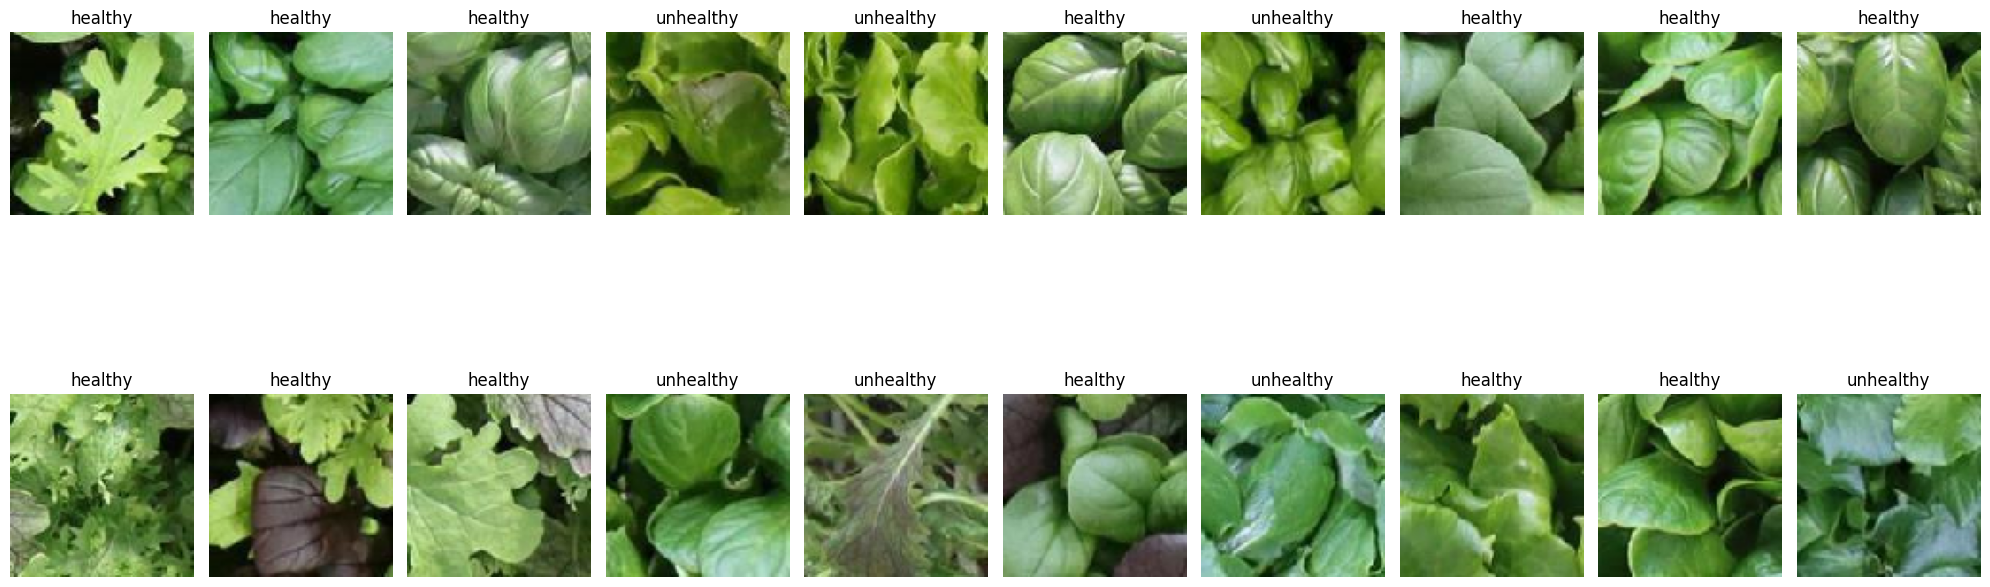

In [6]:
# Visualize first 20 images
n = 20
fig , axes = plt.subplots(int(n/10),10, figsize = (20,9))
axes = axes.reshape((-1,))
for i in range(n):
    axes[i].imshow(np.clip(images[i],0,255))
    axes[i].axis('off')
    axes[i].set_title(labels[i])

plt.tight_layout()

### Clean the dataset

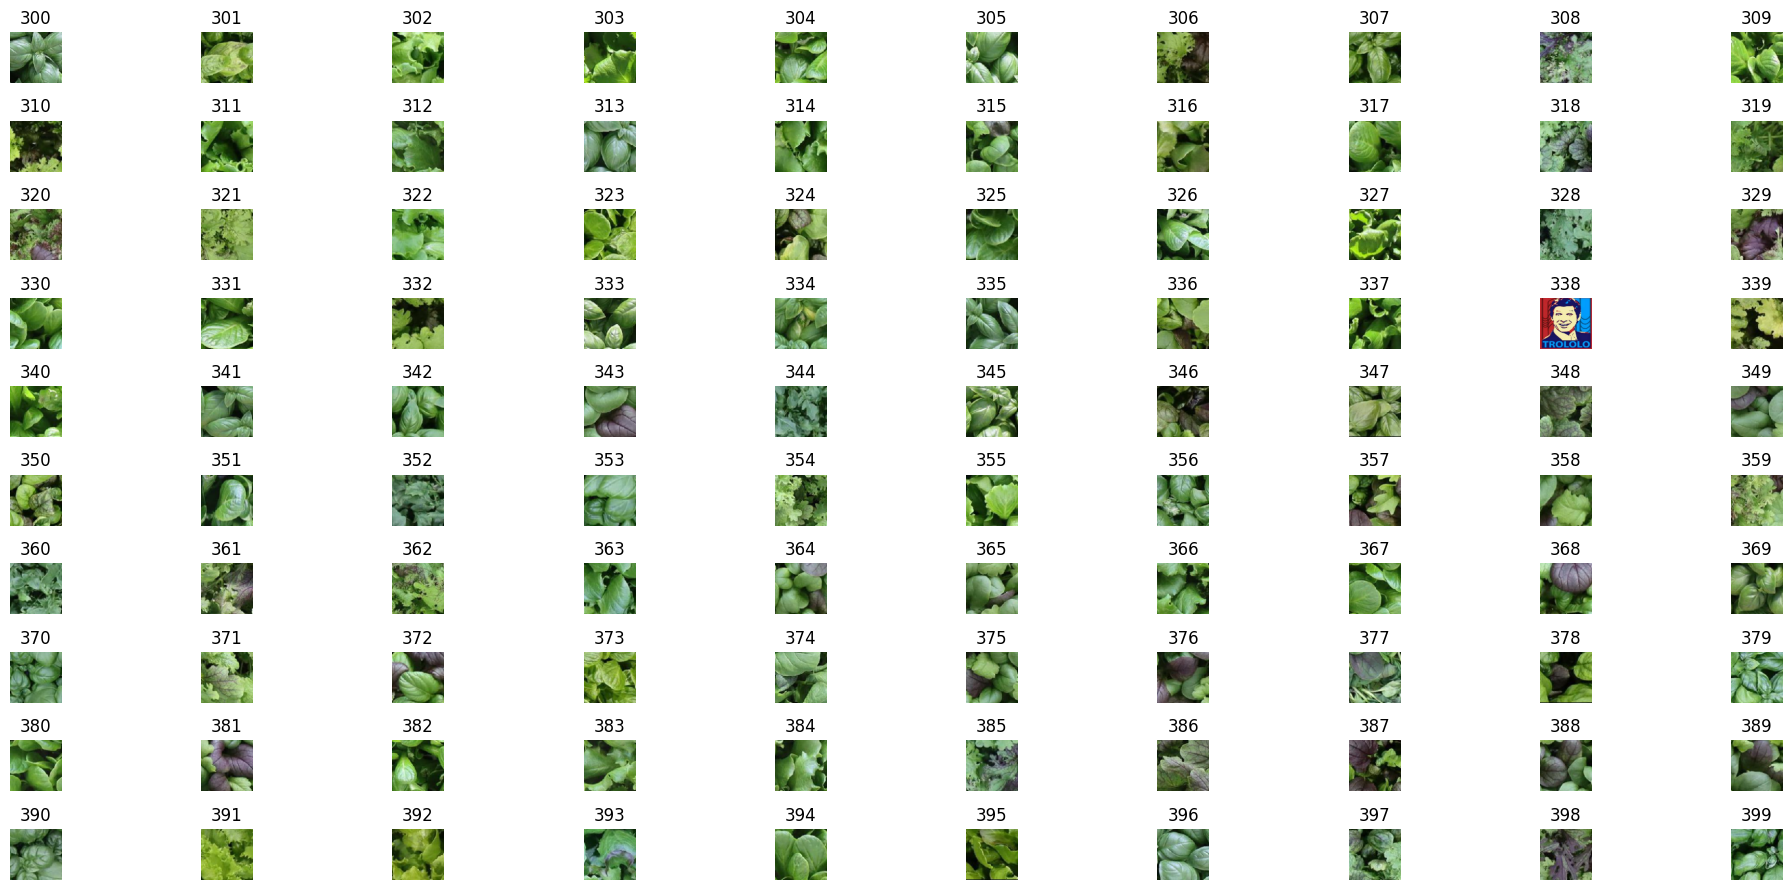

In [7]:
# Visualize interval of 100 images
interval = 3 # first interval -> interval 0
n = 100
fig , axes = plt.subplots(int(n/10),10, figsize = (20,9))
axes = axes.reshape((-1,))
for i in range(n):
    axes[i].imshow(np.clip(images[(interval*n)+i],0,255))
    axes[i].axis('off')
    axes[i].set_title((interval*n)+i)

plt.tight_layout()

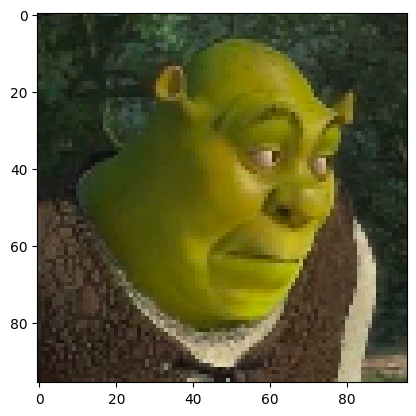

In [8]:
# Save bad images
shrek = images[58]
trololo = images[338]
plt.imshow(np.clip(shrek,0,255))

In [9]:
# Create the mask for bad images
shrek_mask = np.all(images == shrek, axis=(1, 2, 3))
unique_shrek, count_shrek = np.unique(shrek_mask, return_counts= True)
print("There are ", count_shrek[1], " shrek images")

trololo_mask = np.all(images == trololo, axis=(1, 2, 3))
unique_trololo, count_trololo = np.unique(trololo_mask, return_counts= True)
print("and ", count_trololo[1], " trololo images.")

mask_bad = np.logical_or(shrek_mask, trololo_mask)

There are  98  shrek images
and  98  trololo images.


In [10]:
# Delete bad images
images_leaves = images[np.logical_not(mask_bad)]
labels_leaves = labels[np.logical_not(mask_bad)]
print("There are ", len(images_leaves), " leaves images.")

There are  5004  leaves images.


In [11]:
# Find unique images
unique_images, indices_unique_images, count_unique_images = np.unique(images_leaves, return_index= True, return_counts= True, axis= 0)
print("There are ",len(count_unique_images), " unique images.")
images_unique = images_leaves[indices_unique_images]
labels_unique = labels_leaves[indices_unique_images]
labels_unique

There are  4850  unique images.


array(['healthy', 'healthy', 'unhealthy', ..., 'healthy', 'unhealthy',
       'unhealthy'], dtype=object)

In [12]:
# set the definitive dataset
X = images_unique
y = labels_unique

### Create train and validation sets

In [13]:
# Normalize data to the range [0, 1]
X_train_val = (X / 255).astype('float32')

# Create a mapping from label string to values
map = {'healthy':0 , 'unhealthy':1}

# Map labels from string to the corresponding encoding
int_labels = np.array([map[label] for label in y])

In [14]:
uniques, count = np.unique(int_labels, return_counts= True)
N_HEALTHY = count[0]
N_UNHEALTHY = count[1]
N_SAMPLES = N_HEALTHY + N_UNHEALTHY

print("The dataset contains:")
print(N_HEALTHY, " healthy samples")
print(N_UNHEALTHY, " unhealthy samples")
print("For a total of ", N_SAMPLES, " samples")

The dataset contains:
3060  healthy samples
1790  unhealthy samples
For a total of  4850  samples


In [15]:
# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(int_labels)

In [16]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

In [17]:
# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("\n")

# Compare categorical label and "default" label representation
print('Categorical label:', y_train[0])           # Display the categorical label
print('"Default" label:', np.argmax(y_train[0]))   # Display the equivalent numeric label

Training Data Shape: (4365, 96, 96, 3)
Training Label Shape: (4365, 2)
Validation Data Shape: (485, 96, 96, 3)
Validation Label Shape: (485, 2)


Categorical label: [1. 0.]
"Default" label: 0


## LeNet Model

In [18]:
# Define key model parameters
input_shape = X_train.shape[1:]     # Input shape for the model
output_shape = y_train.shape[1]     # Output shape for the model
batch_size = 128                    # Batch size for training
epochs = 200                        # Number of training epochs

# Print the defined parameters
print("Epochs:\t\t", epochs)
print("Batch Size:\t", batch_size)
print("Input Shape:\t", input_shape)
print("Output Shape:\t", output_shape)

Epochs:		 200
Batch Size:	 128
Input Shape:	 (96, 96, 3)
Output Shape:	 2


In [19]:
def build_LeNet(input_shape, output_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=6,
        kernel_size=(5,5),
        padding='same',
        activation='tanh',
        name='conv1'
    )(input_layer)

    pool1 = tfkl.MaxPooling2D(
        pool_size=(2,2),
        name='mp1'
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=16,
        kernel_size=(5,5),
        padding='valid',
        activation='tanh',
        name='conv2'
    )(pool1)

    pool2 = tfkl.MaxPooling2D(
        pool_size =(2,2),
        name='mp2'
    )(conv2)

    flattening_layer=tfkl.Flatten(
        name='flatten'
    )(pool2)

    classifier_layer=tfkl.Dense(
        units=120,
        activation='tanh',
        name='dense1'
    )(flattening_layer)

    classifier_layer = tfkl.Dense(
        units=84,
        activation='tanh',
        name='dense2'
    )(classifier_layer)

    output_layer = tfkl.Dense(
        units=output_shape,
        activation='softmax',
        name='Output'
    )(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='LeNet')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

### Training

In [20]:
# Build the LeNet model and display its summary
model = build_LeNet(input_shape, output_shape)
model.summary()

Model: "LeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 6)         456       
                                                                 
 mp1 (MaxPooling2D)          (None, 48, 48, 6)         0         
                                                                 
 conv2 (Conv2D)              (None, 44, 44, 16)        2416      
                                                                 
 mp2 (MaxPooling2D)          (None, 22, 22, 16)        0         
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dense1 (Dense)              (None, 120)               929400

In [22]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
).history

# Save the trained model
model.save('LeNet_CIFAR10')

Epoch 1/200
35/35 [==============================] - 16s 421ms/step - loss: 0.6494 - accuracy: 0.6312 - val_loss: 0.6562 - val_accuracy: 0.6309
Epoch 2/200
35/35 [==============================] - 13s 372ms/step - loss: 0.6522 - accuracy: 0.6307 - val_loss: 0.6717 - val_accuracy: 0.6309
Epoch 3/200
35/35 [==============================] - 12s 355ms/step - loss: 0.6415 - accuracy: 0.6403 - val_loss: 0.6502 - val_accuracy: 0.6536
Epoch 4/200
35/35 [==============================] - 12s 332ms/step - loss: 0.6202 - accuracy: 0.6692 - val_loss: 0.6524 - val_accuracy: 0.6412
Epoch 5/200
35/35 [==============================] - 12s 340ms/step - loss: 0.6295 - accuracy: 0.6543 - val_loss: 0.6635 - val_accuracy: 0.6392
Epoch 6/200
35/35 [==============================] - 12s 345ms/step - loss: 0.6056 - accuracy: 0.6729 - val_loss: 0.6937 - val_accuracy: 0.6351
Epoch 7/200
35/35 [==============================] - 12s 333ms/step - loss: 0.5944 - accuracy: 0.6845 - val_loss: 0.6419 - val_accuracy:

## Model x

### Training

In [ ]:
# Build the LeNet model and display its summary
model = build_LeNet(input_shape, output_shape)
model.summary()

In [ ]:
# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
).history

In [ ]:
# Save the trained model
model.save("saved_model_name")